# Delta Hedging in the Binomial Model

## 1. Binomial Model

#### Fundamental Information:
- Stock price between timesteps can either move up or down 
- Up and Downmovements have a certain probability
- Assumption that risk-free rate is 0

Advantage: Great to get intuition about Delta hedging and risk neutral pricing, but not real life.

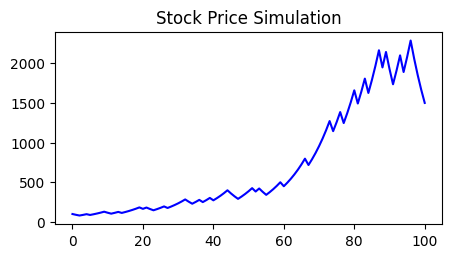

In [228]:
import numpy as np
import matplotlib.pyplot as plt

S_0 = 100   # Initial stock price
u = 1.1     # Up factor
d = 0.9     # Down factor
p = 0.6     # Probability of moving
N = 100      # Number of time steps

prices = [S_0]

for _ in range(N):
    move = np.random.choice([u,d],p=[p, 1-p])
    prices.append(prices[-1] * move)

plt.figure(figsize=(5, 2.5))
plt.plot(prices, linestyle='-', color='b')
plt.title('Stock Price Simulation')
plt.show()

## Concept: No arbitrage

This fundamental concept in finance ensures that there is no free money. In different words, you can't construct a risk free trading strategy, that requires no initial investment with guaranteed profit.

For example, if there is a price difference between a stock on one exchange vs. another one. You can simultaneously buy it in one and sell it in the other and pocket the difference at no risk.

In reality, there are small differences most of the time that quickly get balanced out through market efficiency.

## 2. Option Price in the Binomial Model

Assuming the (call) option is going to expire at the next timestep, what is the price of the option today?

Imagining a portfolio of one option and short selling half of one stock. Using the no arbitrage concept, our assumption is that the total value of our portfilio never changes, we can calculate the value of the option:

#### Value of Call option given todays and tomorrows stock price:
**Value of portfolio today**: $x - 0.5 * 100$ with $x$ being the value of the option

**Values of portfolio tomorrow**: $1 -0.5*101$ (Payoff of 1) and $0 - 0.5 *99$ (Payoff of 0)

Assuming all of these have to be the same, the value of the option is therefore: $x=0.5$


## 3. Delta Hedging

Delta Hedging is a risk- neutral hedging strategy. By hedging the option with the underlying, in the ideal case that this binomial model is, we can create a risk neutral portfolio of one option and one asset.

#### Single Day Expiry:

**Riskfree rate = 0**:

Delta is defined as the following: $ \Delta = \frac{\text{Range of option payoffs}}{\text{Range of stock prices}}$ In our previous example with our stock price equal to 100, this looks like the following: $ \Delta = \frac{1-0}{101-99}= \frac{1}{2}$ 


**Riskfree rate = r**:

If we do have a risk free rate $r=0.1$, then despite that the value of our portfolio shouldn't change from current to next day.
To achieve this we figure out how much cash/bond we need to hold to make this:

Using a discount factor: $\frac{1}{1+r/252} = 0.9996$, we can calculate the present day portfolio value using the following equation: $ c -0.5* 100 = -0.5*99*0.996$. This means that the cash plus the short position needs to be equal to the short position (with the option pay off) plus some discount price. The whole value is discounted, since due to no arbitrage it must behave like a pure risk free investment.

#### General Expiry:

Delta for a general expiry is defined as the following: $ \Delta = \frac{V^+ - V^-}{(u-v)S}$ where $V^+$ and $V^-$ are the values of the option if the price goes up or down respectively.
In the binomial tree these are calculated by starting at the payoffs at expiration and working backwards node by node.


In [229]:
S_0 = 100   # Initial stock price
p_r = 0.5  # Risk-neutral probability
T = 1
N = 10     # Number of time steps
dt = T / N
sigma = 0.2  # Volatility

u = 1 + sigma * np.sqrt(dt)
d = 1 - sigma * np.sqrt(dt)

discount_factor = np.exp(-0.05 * dt)  # Assuming a risk-free rate of 5%

stock_prices = {(0,0): S_0}

for i in range(1, N + 1):
    for j in range(i + 1):
        stock_prices[(i, j)] = stock_prices[(i - 1, j - 1)] * u if j > 0 else stock_prices[(i - 1, j)] * d

expected_payoffs = {(N, j): max(0, stock_prices[(N, j)] - S_0) for j in range(N + 1)}

for i in range(N - 1, -1, -1):
    for j in range(i + 1):
        expected_payoffs[(i, j)] = (p_r * expected_payoffs[(i + 1, j + 1)] + (1 - p_r) * expected_payoffs[(i + 1, j)]) * discount_factor


In [230]:
import networkx as nx
import matplotlib.pyplot as plt

def draw_binomial_tree(tree):

    G = nx.DiGraph()

    # Add nodes and directed edges
    for pos, value in tree.items():
        G.add_node(pos, value=value)
        col, row = pos
        if (col + 1, row) in tree:
            G.add_edge(pos, (col + 1, row))
        if (col + 1, row + 1) in tree:
            G.add_edge(pos, (col + 1, row + 1))

    # Positioning: horizontal layout (x = col, y = center-aligned row)
    pos = {node: (node[0], node[1] - node[0]/2) for node in G.nodes()}

    # Draw graph
    plt.figure(figsize=(12, 4))
    nx.draw(G, pos, with_labels=False, node_size=150, node_color='white', edge_color='black', arrows=False)

    # Draw labels for non-zero payoffs
    labels = {node: f"{value:.2f}" for node, value in tree.items()}
    nx.draw_networkx_labels(G, pos, labels=labels, font_color='black', font_weight='bold', font_size=9)

    plt.axis('off')
    plt.show()

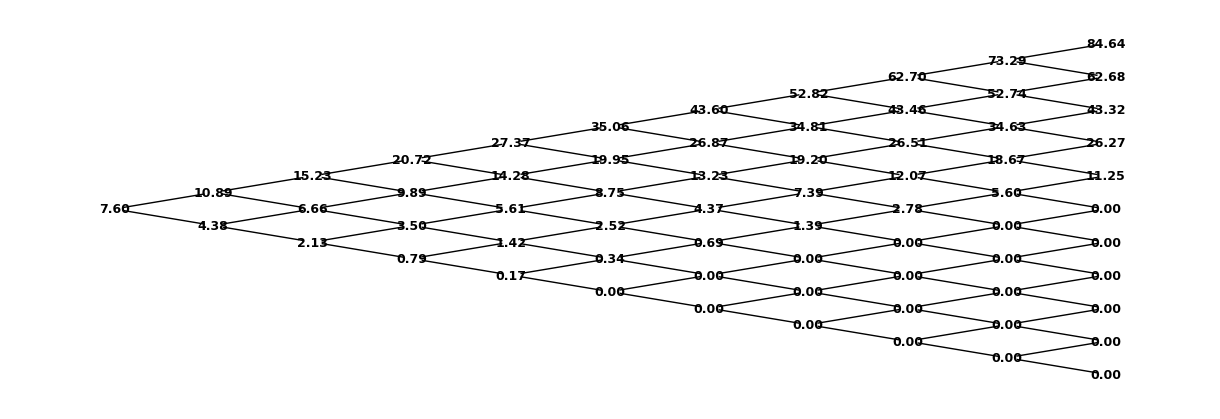

In [231]:
draw_binomial_tree(expected_payoffs)

### Implementaiton

Given these previous findings, let's make a hedging strategy that hedges an option for the entirty of its life time. Since we are dealing with the ideal case (with riskfree rate = 0, dividends = 0, costs = 0), we will be able to rehedge each timestep.

First lets simulate a stockprice given by the binomial model. 

In [ ]:
sigma = 0.1  # Volatility
mu = 0.1

r = 0.04  # Risk-free rate

S_0 = 100  # Initial stock price
Strike = 100  # Strike price

N = 1000  # Number of time steps
T = 1  # Total time in years
dt = T / N  # Time step size

u = np.exp(sigma * np.sqrt(dt))  # Up factor
d = np.exp(-sigma * np.sqrt(dt))  # Down factor
p_r = (np.exp(r*dt) - d)/(u - d)  # Risk-neutral probability
p = (np.exp(mu*dt) - d)/(u - d)  #actual probability

discount_factor = np.exp(-r * dt)  # Assuming a risk-free rate of 5%
cash = 200

possible_stock_prices = {(0,0): S_0}

for i in range(1, N + 1):
    for j in range(i + 1):
        possible_stock_prices[(i, j)] = possible_stock_prices[(i - 1, j - 1)] * u if j > 0 else possible_stock_prices[(i - 1, j)] * d

expected_payoffs = {(N, j): max(0, possible_stock_prices[(N, j)] - Strike) for j in range(N + 1)}

for i in range(N - 1, -1, -1):
    for j in range(i + 1):
        expected_payoffs[(i, j)] = (p_r * expected_payoffs[(i + 1, j + 1)] + (1 - p_r) * expected_payoffs[(i + 1, j)]) * discount_factor

deltas = {}

for i in range(N):
    for j in range(i+1):
        deltas[(i,j)] = (expected_payoffs[(i + 1, j + 1)] - expected_payoffs[(i + 1, j)]) / ((u - d) * possible_stock_prices[(i, j)])

random_path = [(0,0)]  # Start at the root node
for i in range(1, N):
    _,old = random_path[-1]
    new_pos = old + np.random.choice([1, 0], p=[p, 1 - p])

    random_path.append((i, new_pos))

stock_series  = np.array([possible_stock_prices[pos] for pos in random_path])
option_series = np.array([expected_payoffs[pos]   for pos in random_path])
delta_series  = np.array([deltas[pos]              for pos in random_path])

cash_series = np.zeros_like(stock_series)

cash_series[0] = option_series[0] - delta_series[0]*stock_series[0]

for i in range(1, len(stock_series)):
    cash_series[i] = cash_series[i-1] / discount_factor
    cash_series[i] -= (delta_series[i] - delta_series[i-1]) * stock_series[i]

portfolio_series = delta_series*stock_series + cash_series

pnl_series = portfolio_series - option_series

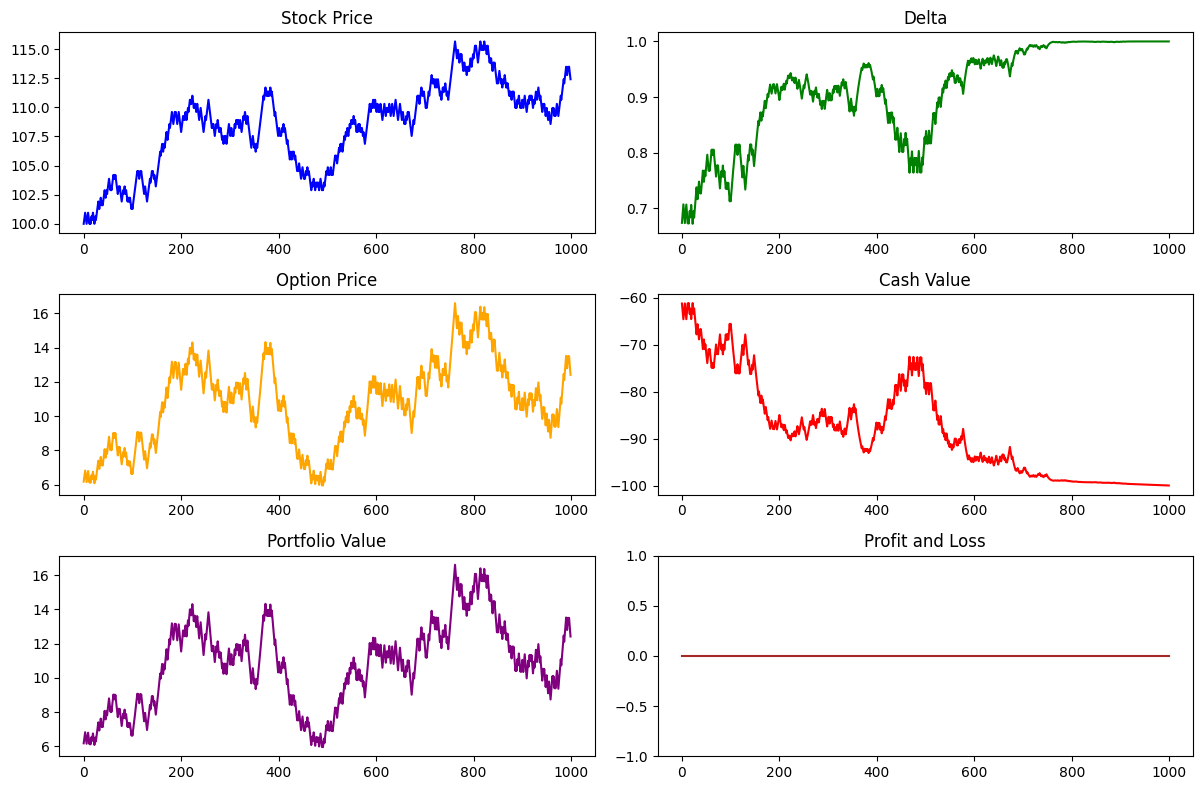

In [310]:
fig,ax = plt.subplots(nrows=3, ncols=2,figsize=(12, 8),)
ax[0,0].plot(stock_series, label='Stock Price', color='blue')
ax[0,0].set_title('Stock Price')

ax[1,0].plot(option_series, label='Option Price', color='orange')
ax[1,0].set_title('Option Price')

ax[0,1].plot(delta_series, label='Delta', color='green')
ax[0,1].set_title('Delta')

ax[1,1].plot(cash_series, label='Cash Value', color='red')
ax[1,1].set_title('Cash Value')

ax[2,0].plot(portfolio_series, label='Portfolio Value', color='purple')
ax[2,0].set_title('Portfolio Value')

ax[2,1].plot(pnl_series, label='P&L', color='brown')
ax[2,1].set_title('Profit and Loss')
ax[2,1].set_ylim(bottom=-1, top=1)

plt.tight_layout()
plt.show()

Here you can see that the portfolio consisting of cash, long option and short stock, is unaffected by risk. In this Ideal model we have effectively completely hedged away all risk. In this simple Binomial Tree model, this effectively hedges away all risk. 